# EPP Screening Model - Advanced Metrics System (v1.1.1+)

This notebook demonstrates the **comprehensive metrics extraction system** introduced in v1.1.0+ and creates professional visualizations for analysis.

**Features**:
- **50+ Metrics** automatically extracted from all 9 sheets
- **Type-safe access** with Pydantic validation
- **6 Metric categories**: Cash Flow, Financing, Accounting, Returns, Assumptions, Summary_A
- **Annual aggregations** from Summary_A sheet
- **Export integration** with all output formats

**Author**: EPP Analytics Team  
**Version**: 1.1.1+  
**Date**: 2025-10-25

## Setup and Imports

In [1]:
# Standard library imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Change to project root directory if we're in examples/
if Path.cwd().name == 'examples':
    os.chdir('..')
    print(f"Changed working directory to: {Path.cwd()}")
else:
    print(f"Working directory: {Path.cwd()}")

# Verify config file exists
config_path = Path('config/config.toml')
if config_path.exists():
    print(f"✓ Config file found: {config_path.absolute()}")
else:
    print(f"❌ Config file NOT found at: {config_path.absolute()}")
    print(f"   Please ensure config/config.toml exists in the project root")

# EPP package imports - using v1.1.1+ features
from epp_screening_model_v3.models import ACCUModel

# Configure pandas and matplotlib
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Ensure results directory exists
Path('results').mkdir(exist_ok=True)

print("\n✓ All imports successful")
print("✓ Results directory ready")

Changed working directory to: /Users/jim/Development/Wollemi/epp-example-external-usage
✓ Config file found: /Users/jim/Development/Wollemi/epp-example-external-usage/config/config.toml

✓ All imports successful
✓ Results directory ready


## Part 1: Run Model and Access Metrics

The new metrics system automatically extracts 50+ metrics from all sheets after model execution.

In [2]:
print("="*80)
print("Running EPP Screening Model - Base Case")
print("="*80)

# Initialize and run model
model = ACCUModel(config_path='config/config.toml')
results = model.calculate_full_model()

print(f"\n✓ Model execution complete")
print(f"  Status: {'SUCCESS' if results.success else 'FAILED'}")
print(f"  Execution time: {results.execution_time_seconds:.3f}s")
print(f"  Sheets calculated: {len(results.sheet_results)}")

Running EPP Screening Model - Base Case

✓ Model execution complete
  Status: SUCCESS
  Execution time: 0.072s
  Sheets calculated: 9


## Part 2: Display Comprehensive Metrics

Access the extracted metrics from the new v1.1.0 metrics framework.

In [3]:
print("="*80)
print("EXTRACTED METRICS SUMMARY")
print("="*80)

# Access metrics object
metrics = results.metrics

# 📊 Cash Flow Metrics (PrjCF_Qtr)
if metrics.cash_flows:
    cf = metrics.cash_flows
    print("\n📊 CASH FLOW METRICS (PrjCF_Qtr)")
    print("-" * 80)
    print(f"  Total Revenue:              ${cf.total_revenue:>15,.0f}")
    if cf.total_accu_revenue:
        accu_pct = (cf.total_accu_revenue / cf.total_revenue * 100) if cf.total_revenue else 0
        print(f"    - ACCU Revenue:           ${cf.total_accu_revenue:>15,.0f}  ({accu_pct:.1f}%)")
    if cf.total_non_accu_revenue:
        non_accu_pct = (cf.total_non_accu_revenue / cf.total_revenue * 100) if cf.total_revenue else 0
        print(f"    - Non-ACCU Revenue:       ${cf.total_non_accu_revenue:>15,.0f}  ({non_accu_pct:.1f}%)")
    print(f"  Total OPEX:                 ${cf.total_opex:>15,.0f}")
    print(f"  Total CAPEX:                ${cf.total_capex:>15,.0f}")
    print(f"  Net Operating Cash Flow:    ${cf.net_operating_cash_flow:>15,.0f}")
    print(f"  Total ACCU Volume:          {cf.total_accu_volume:>15,.0f} units")

# 💰 Financing Metrics (Financing_Qtr)
if metrics.financing:
    fin = metrics.financing
    print("\n💰 FINANCING METRICS (Financing_Qtr)")
    print("-" * 80)
    print(f"  Total Debt Drawn:           ${fin.total_debt_drawn:>15,.0f}")
    print(f"  Peak Debt:                  ${fin.peak_debt:>15,.0f}")
    print(f"  Total Interest Paid:        ${fin.total_interest_paid:>15,.0f}")
    print(f"  Total Principal Repaid:     ${fin.total_principal_repaid:>15,.0f}")
    print(f"  Final Debt Balance:         ${fin.final_debt_balance:>15,.0f}")
    if fin.debt_service_coverage_ratio_avg:
        print(f"  Average DSCR:               {fin.debt_service_coverage_ratio_avg:>16.2f}x")

# 📈 Summary_A Annual Metrics
if metrics.summary_a:
    sa = metrics.summary_a
    print("\n📈 ANNUAL SUMMARY METRICS (Summary_A)")
    print("-" * 80)
    print("\n  Sources & Uses:")
    print(f"    Total Equity:             ${sa.total_equity:>15,.0f}")
    print(f"    Total Debt:               ${sa.total_debt:>15,.0f}")
    print(f"    Total Sources:            ${sa.total_sources:>15,.0f}")
    print(f"    Total Uses:               ${sa.total_uses:>15,.0f}")
    balance_status = "✅ Balanced" if sa.sources_uses_balanced else "⚠️  Imbalanced"
    print(f"    Balance Check:            ${sa.sources_uses_balance:>15,.2f}  {balance_status}")
    
    print("\n  Cash Flow Waterfall:")
    print(f"    Total Revenue:            ${sa.total_revenue:>15,.0f}")
    print(f"    EBITDA:                   ${sa.ebitda:>15,.0f}")
    if sa.ebitda_margin:
        print(f"    EBITDA Margin:            {sa.ebitda_margin:>16.2%}")
    print(f"    CFADS:                    ${sa.cfads:>15,.0f}")
    if sa.levered_yield:
        print(f"    Levered Yield:            {sa.levered_yield:>16.2%}")
    print(f"    Net Cash Flow:            ${sa.net_cash_flow:>15,.0f}")

# 📊 Financial Returns (Returns_Prj)
if metrics.returns:
    ret = metrics.returns
    print("\n📊 FINANCIAL RETURNS (Returns_Prj)")
    print("-" * 80)
    if ret.unlevered_irr:
        print(f"  Unlevered IRR:              {ret.unlevered_irr:>16.4%}")
    if ret.levered_irr:
        print(f"  Levered IRR:                {ret.levered_irr:>16.4%}")

print("\n" + "="*80)

EXTRACTED METRICS SUMMARY

📊 CASH FLOW METRICS (PrjCF_Qtr)
--------------------------------------------------------------------------------
  Total Revenue:              $        125,154
    - ACCU Revenue:           $        125,154  (100.0%)
  Total OPEX:                 $         -8,883
  Total CAPEX:                $         -2,842
  Net Operating Cash Flow:    $        136,880
  Total ACCU Volume:                1,315,381 units

💰 FINANCING METRICS (Financing_Qtr)
--------------------------------------------------------------------------------
  Total Debt Drawn:           $          4,320
  Peak Debt:                  $          4,320
  Total Interest Paid:        $         -7,904
  Total Principal Repaid:     $              0
  Final Debt Balance:         $             -0

📈 ANNUAL SUMMARY METRICS (Summary_A)
--------------------------------------------------------------------------------

  Sources & Uses:
    Total Equity:             $          3,518
    Total Debt:          

## Part 3: Extract Time Series Data for Visualization

Get quarterly and annual data for charts.

In [4]:
# Helper function to extract quarterly data
def extract_quarterly_data(sheet_results, sheet_name, variable_name):
    """Extract quarterly time series from sheet results."""
    sheet = sheet_results.get(sheet_name)
    if not sheet:
        return pd.Series(dtype=float)
    
    data = sheet.get_value(variable_name)
    if isinstance(data, dict):
        # Handle nested structure
        if 'data' in data:
            data = data['data']
        return pd.Series(data, name=variable_name)
    return pd.Series(dtype=float)

# Extract ACCU data (quarterly)
accu_volumes = extract_quarterly_data(results.sheet_results, 'Ass_Dyn', 'accu_volumes')
accu_issuance = extract_quarterly_data(results.sheet_results, 'PrjCF_Qtr', 'total')

# Extract annual data from Summary_A
annual_revenue = extract_quarterly_data(results.sheet_results, 'Summary_A', 'summary_a_total_revenue')
annual_net_cash_flow = extract_quarterly_data(results.sheet_results, 'Summary_A', 'summary_a_net_cash_flow')

# Create dataframes
df_accu = pd.DataFrame({
    'ACCU Volumes': accu_volumes,
    'ACCU Issuance': accu_issuance
})

df_annual = pd.DataFrame({
    'Revenue': annual_revenue,
    'Net Cash Flow': annual_net_cash_flow
})
df_annual['Fiscal Year'] = [2025 + i for i in range(len(df_annual))]

print("✓ Time series data extracted")
print(f"  ACCU data (quarterly): {len(df_accu)} quarters")
print(f"    - Non-zero volumes: {(df_accu['ACCU Volumes'] != 0).sum()}")
print(f"    - Non-zero issuance: {(df_accu['ACCU Issuance'] != 0).sum()}")
print(f"  Annual data: {len(df_annual)} years (FY{df_annual['Fiscal Year'].min()}-FY{df_annual['Fiscal Year'].max()})")

✓ Time series data extracted
  ACCU data (quarterly): 109 quarters
    - Non-zero volumes: 23
    - Non-zero issuance: 23
  Annual data: 28 years (FY2025-FY2052)


## Part 4: Chart 1 - ACCU Volumes and Issuance

Recreate the ACCU chart similar to Excel Summary sheet.

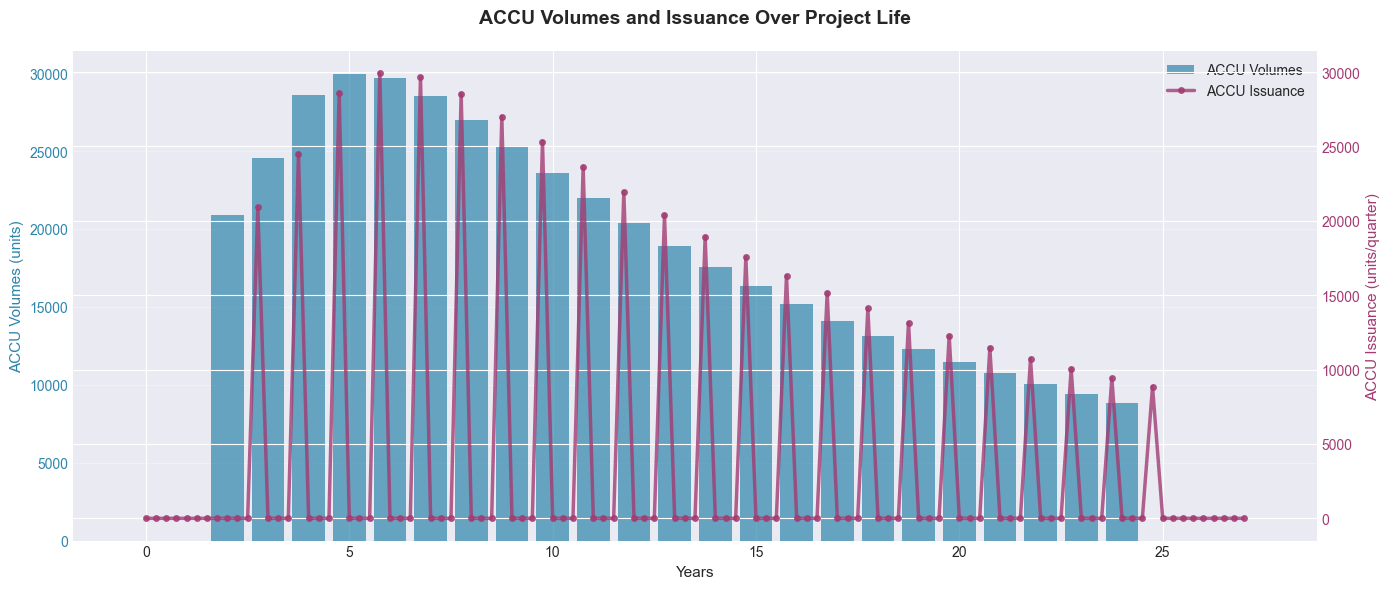

✓ Chart saved: results/metrics_accu_volumes_issuance.png


In [5]:
# Create ACCU chart
fig, ax1 = plt.subplots(figsize=(14, 6))

# Convert quarter index to years
quarters = df_accu.index
years = quarters / 4

# Plot ACCU volumes (bar chart)
color1 = '#2E86AB'
ax1.bar(years, df_accu['ACCU Volumes'], alpha=0.7, color=color1, label='ACCU Volumes')
ax1.set_xlabel('Years', fontsize=11)
ax1.set_ylabel('ACCU Volumes (units)', color=color1, fontsize=11)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(axis='y', alpha=0.3)

# Create second y-axis for issuance
ax2 = ax1.twinx()
color2 = '#A23B72'
ax2.plot(years, df_accu['ACCU Issuance'], color=color2, linewidth=2.5, 
         marker='o', markersize=4, label='ACCU Issuance', alpha=0.8)
ax2.set_ylabel('ACCU Issuance (units/quarter)', color=color2, fontsize=11)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('ACCU Volumes and Issuance Over Project Life', fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', framealpha=0.95)

plt.tight_layout()
plt.savefig('results/metrics_accu_volumes_issuance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved: results/metrics_accu_volumes_issuance.png")

## Part 5: Chart 2 - Annual Revenue and Net Cash Flow

Annual aggregation from Summary_A sheet (FY2025-FY2052).

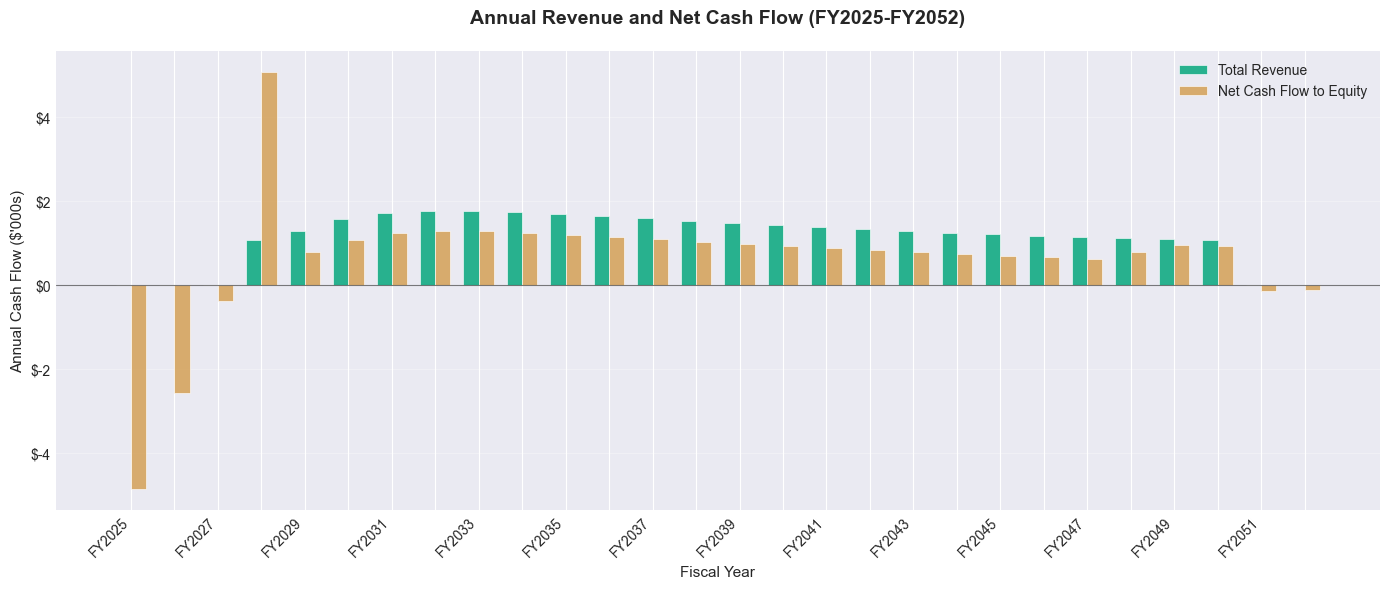

✓ Chart saved: results/metrics_revenue_cashflow_annual.png


In [6]:
# Create annual cash flow chart
fig, ax = plt.subplots(figsize=(14, 6))

fiscal_years = df_annual['Fiscal Year']
width = 0.35
x_pos = np.arange(len(fiscal_years))

color_revenue = '#06A77D'
color_net_cf = '#D4A056'

ax.bar(x_pos - width/2, df_annual['Revenue'], width=width, 
       alpha=0.85, color=color_revenue, label='Total Revenue', edgecolor='white', linewidth=0.5)
ax.bar(x_pos + width/2, df_annual['Net Cash Flow'], width=width, 
       alpha=0.85, color=color_net_cf, label='Net Cash Flow to Equity', edgecolor='white', linewidth=0.5)

ax.set_xlabel('Fiscal Year', fontsize=11)
ax.set_ylabel('Annual Cash Flow ($\'000s)', fontsize=11)
ax.set_title(f'Annual Revenue and Net Cash Flow (FY{fiscal_years.min()}-FY{fiscal_years.max()})', 
             fontsize=14, fontweight='bold', pad=20)

# Set x-axis labels
ax.set_xticks(x_pos)
ax.set_xticklabels([f'FY{y}' for y in fiscal_years], rotation=45, ha='right')

# Show every 2nd year
for i, label in enumerate(ax.xaxis.get_ticklabels()):
    if i % 2 != 0:
        label.set_visible(False)

ax.legend(loc='upper right', framealpha=0.95)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}'))

plt.tight_layout()
plt.savefig('results/metrics_revenue_cashflow_annual.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved: results/metrics_revenue_cashflow_annual.png")

## Part 6: Quick Financial Summary Table

Display key metrics in a formatted table.

In [7]:
# Create summary table from metrics
summary_data = []

if metrics.summary_a:
    sa = metrics.summary_a
    summary_data.extend([
        ['Total Equity', f'${sa.total_equity:,.0f}'],
        ['Total Debt', f'${sa.total_debt:,.0f}'],
        ['Debt/Equity Ratio', f'{sa.total_debt / sa.total_equity:.2f}x' if sa.total_equity else 'N/A'],
        ['Total Revenue', f'${sa.total_revenue:,.0f}'],
        ['EBITDA', f'${sa.ebitda:,.0f}'],
        ['EBITDA Margin', f'{sa.ebitda_margin:.2%}' if sa.ebitda_margin else 'N/A'],
        ['CFADS', f'${sa.cfads:,.0f}'],
        ['Net Cash Flow', f'${sa.net_cash_flow:,.0f}'],
        ['Levered Yield', f'{sa.levered_yield:.2%}' if sa.levered_yield else 'N/A'],
    ])

if metrics.returns:
    ret = metrics.returns
    if ret.unlevered_irr:
        summary_data.append(['Unlevered IRR', f'{ret.unlevered_irr:.2%}'])
    if ret.levered_irr:
        summary_data.append(['Levered IRR', f'{ret.levered_irr:.2%}'])

if metrics.financing:
    fin = metrics.financing
    if fin.debt_service_coverage_ratio_avg:
        summary_data.append(['Average DSCR', f'{fin.debt_service_coverage_ratio_avg:.2f}x'])

df_summary = pd.DataFrame(summary_data, columns=['Metric', 'Value'])
df_summary = df_summary.set_index('Metric')

print("\n" + "="*60)
print("KEY FINANCIAL METRICS - BASE CASE")
print("="*60)
display(df_summary)


KEY FINANCIAL METRICS - BASE CASE


,Value
Metric,
Total Equity,"$3,518"
Total Debt,"$4,320"
Debt/Equity Ratio,1.23x
Total Revenue,"$32,357"
EBITDA,"$29,395"
EBITDA Margin,91.85%
CFADS,"$21,889"
Net Cash Flow,"$18,205"
Levered Yield,28.03%


## Part 7: Scenario Analysis with Metrics

Compare multiple scenarios using the metrics framework.

In [8]:
print("="*80)
print("SCENARIO ANALYSIS - Property Price Sensitivity")
print("="*80)

# Define scenarios
property_prices = [3000, 4000, 5000, 6000, 7000]  # in $'000s
scenario_results = []

for price in property_prices:
    print(f"\nRunning: Property Price = ${price/1000:.1f}M")
    
    # Create model and modify config directly
    model_scenario = ACCUModel(config_path='config/config.toml')
    
    # Modify the static config parameter
    model_scenario.config.static.config_property_price = float(price)
    
    # Run model with modified config
    run_results = model_scenario.calculate_full_model()
    
    # Extract metrics
    scenario_results.append({
        'Property Price ($M)': price / 1000,
        'Levered IRR': run_results.metrics.returns.levered_irr if run_results.metrics.returns else None,
        'Unlevered IRR': run_results.metrics.returns.unlevered_irr if run_results.metrics.returns else None,
        'Total Equity': run_results.metrics.summary_a.total_equity if run_results.metrics.summary_a else None,
        'Total Revenue': run_results.metrics.summary_a.total_revenue if run_results.metrics.summary_a else None,
        'Net Cash Flow': run_results.metrics.summary_a.net_cash_flow if run_results.metrics.summary_a else None,
        'EBITDA Margin': run_results.metrics.summary_a.ebitda_margin if run_results.metrics.summary_a else None,
    })

df_scenarios = pd.DataFrame(scenario_results)
print("\n✓ Scenario analysis complete\n")
display(df_scenarios)

SCENARIO ANALYSIS - Property Price Sensitivity

Running: Property Price = $3.0M

Running: Property Price = $4.0M

Running: Property Price = $5.0M

Running: Property Price = $6.0M

Running: Property Price = $7.0M

✓ Scenario analysis complete



,Property Price ($M),Levered IRR,Unlevered IRR,Total Equity,Total Revenue,Net Cash Flow,EBITDA Margin
0,3.0,0.2074,0.1803,3371.2969,32356.6283,20985.9213,0.9185
1,4.0,0.1820,0.1546,3468.7969,32356.6283,19131.9028,0.9185
2,5.0,0.1602,0.1344,3566.2969,32356.6283,17277.8843,0.9185
3,6.0,0.1408,0.1180,3663.7969,32356.6283,15423.8657,0.9185
4,7.0,0.1231,0.1042,3761.2969,32356.6283,13569.8472,0.9185


## Part 8: Visualize Scenario Results

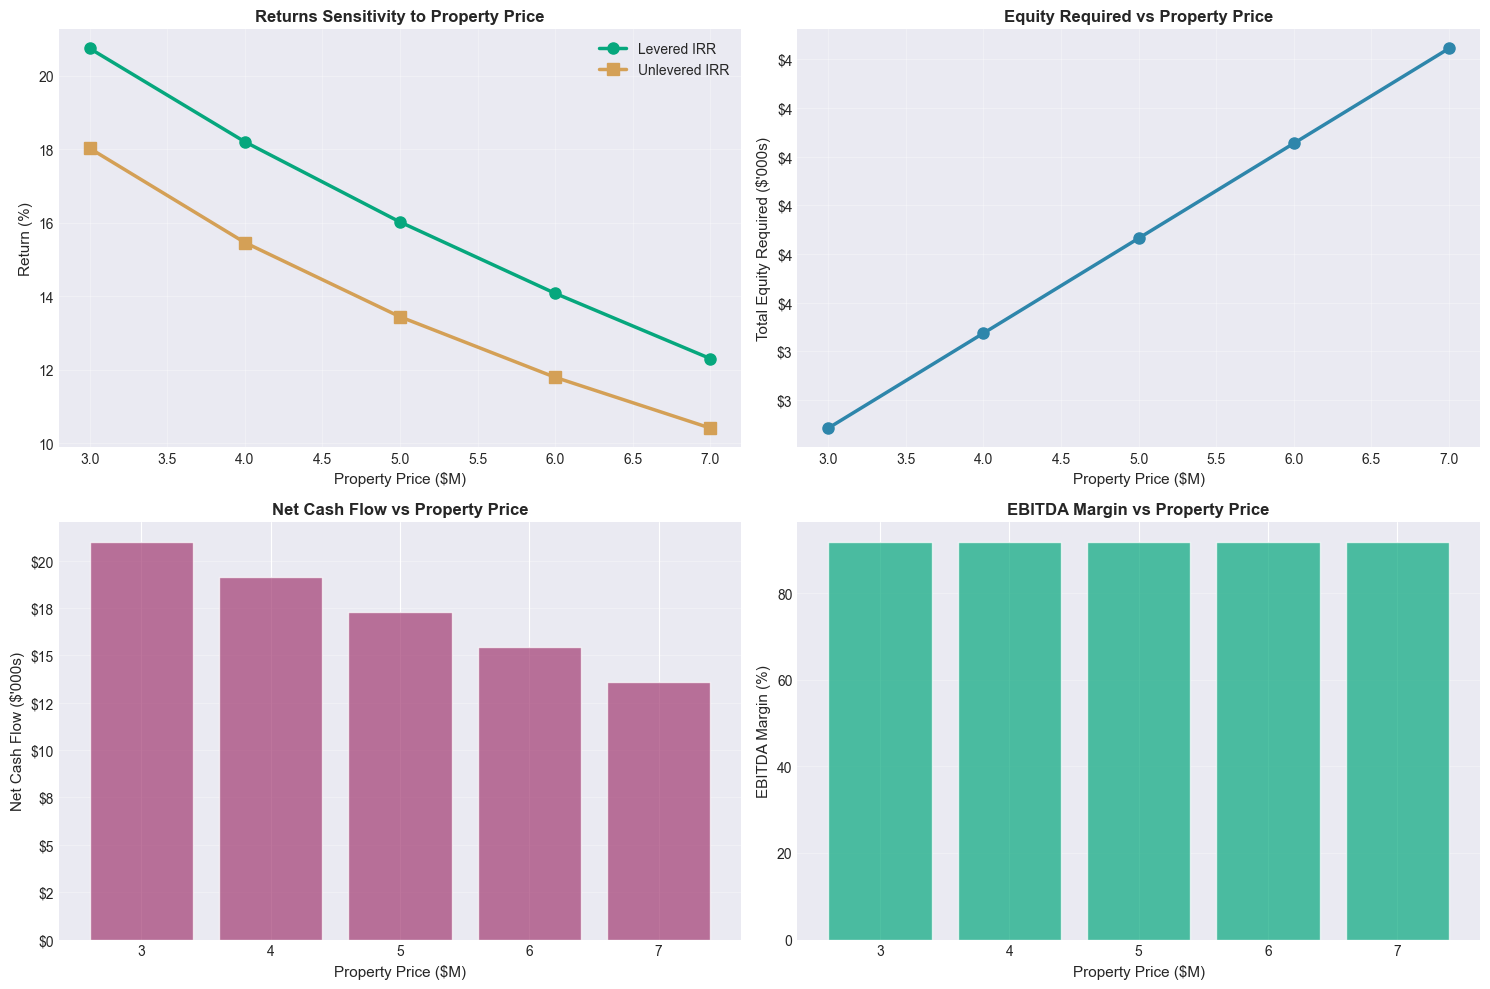

✓ Chart saved: results/metrics_property_price_sensitivity.png


In [9]:
# Create comprehensive scenario visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Chart 1: Returns vs Property Price
ax1.plot(df_scenarios['Property Price ($M)'], df_scenarios['Levered IRR'] * 100, 
         marker='o', label='Levered IRR', linewidth=2.5, markersize=8, color='#06A77D')
ax1.plot(df_scenarios['Property Price ($M)'], df_scenarios['Unlevered IRR'] * 100, 
         marker='s', label='Unlevered IRR', linewidth=2.5, markersize=8, color='#D4A056')
ax1.set_xlabel('Property Price ($M)', fontsize=11)
ax1.set_ylabel('Return (%)', fontsize=11)
ax1.set_title('Returns Sensitivity to Property Price', fontsize=12, fontweight='bold')
ax1.legend(framealpha=0.95)
ax1.grid(alpha=0.3)

# Chart 2: Equity Required
ax2.plot(df_scenarios['Property Price ($M)'], df_scenarios['Total Equity'], 
         marker='o', linewidth=2.5, markersize=8, color='#2E86AB')
ax2.set_xlabel('Property Price ($M)', fontsize=11)
ax2.set_ylabel('Total Equity Required ($\'000s)', fontsize=11)
ax2.set_title('Equity Required vs Property Price', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}'))

# Chart 3: Net Cash Flow
ax3.bar(df_scenarios['Property Price ($M)'], df_scenarios['Net Cash Flow'], 
        color='#A23B72', alpha=0.7, edgecolor='white', linewidth=1)
ax3.set_xlabel('Property Price ($M)', fontsize=11)
ax3.set_ylabel('Net Cash Flow ($\'000s)', fontsize=11)
ax3.set_title('Net Cash Flow vs Property Price', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}'))

# Chart 4: EBITDA Margin
ax4.bar(df_scenarios['Property Price ($M)'], df_scenarios['EBITDA Margin'] * 100, 
        color='#06A77D', alpha=0.7, edgecolor='white', linewidth=1)
ax4.set_xlabel('Property Price ($M)', fontsize=11)
ax4.set_ylabel('EBITDA Margin (%)', fontsize=11)
ax4.set_title('EBITDA Margin vs Property Price', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/metrics_property_price_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved: results/metrics_property_price_sensitivity.png")

## Part 9: Export Metrics to Excel

Export all extracted metrics to Excel for further analysis.

In [10]:
# Create comprehensive metrics export
with pd.ExcelWriter('results/metrics_comprehensive_export.xlsx', engine='openpyxl') as writer:
    # Sheet 1: Summary metrics
    df_summary.to_excel(writer, sheet_name='Summary')
    
    # Sheet 2: Scenario comparison
    df_scenarios.to_excel(writer, sheet_name='Scenarios', index=False)
    
    # Sheet 3: Quarterly ACCU data
    df_accu.to_excel(writer, sheet_name='ACCU Data')
    
    # Sheet 4: Annual cash flows
    df_annual.to_excel(writer, sheet_name='Annual Cash Flows', index=False)
    
    # Sheet 5: Detailed metrics (if available)
    if metrics.cash_flows:
        cf_data = [
            ['Total Revenue', metrics.cash_flows.total_revenue],
            ['ACCU Revenue', metrics.cash_flows.total_accu_revenue],
            ['Total OPEX', metrics.cash_flows.total_opex],
            ['Total CAPEX', metrics.cash_flows.total_capex],
            ['Net Operating CF', metrics.cash_flows.net_operating_cash_flow],
            ['Total ACCU Volume', metrics.cash_flows.total_accu_volume],
        ]
        pd.DataFrame(cf_data, columns=['Metric', 'Value']).to_excel(
            writer, sheet_name='Cash Flow Metrics', index=False
        )

print("✓ Exported to: results/metrics_comprehensive_export.xlsx")
print("  Sheets: Summary, Scenarios, ACCU Data, Annual Cash Flows, Cash Flow Metrics")

✓ Exported to: results/metrics_comprehensive_export.xlsx
  Sheets: Summary, Scenarios, ACCU Data, Annual Cash Flows, Cash Flow Metrics


## Summary

This notebook demonstrated the **v1.1.0+ comprehensive metrics extraction system**:

### ✅ Key Features Used

1. **Automatic Metrics Extraction**
   - `results.metrics.cash_flows` - Quarterly cash flow metrics
   - `results.metrics.financing` - Debt financing metrics
   - `results.metrics.summary_a` - Annual summary metrics
   - `results.metrics.returns` - Financial return metrics

2. **Type-Safe Access**
   - Pydantic validation ensures data integrity
   - IDE autocomplete for all metrics
   - Clear error messages for missing data

3. **Comprehensive Coverage**
   - 50+ metrics across 6 categories
   - Quarterly and annual time series
   - Sources & uses, cash flow waterfall
   - Debt service coverage ratios

4. **Easy Visualization**
   - Direct access to time series data
   - No manual data extraction needed
   - Professional charts and exports

5. **Scenario Analysis (v1.1.1+)**
   - Direct config modification for parameter sweeps
   - Programmatic scenario execution
   - Automated metrics comparison

### 🎯 Advantages Over Previous Approach

- **No Manual Extraction**: Metrics automatically available after model execution
- **Consistent API**: Same pattern across all sheets and metrics
- **Type Safety**: Compile-time checks and validation
- **Documentation**: Self-documenting with clear field names
- **Export Ready**: Direct integration with Excel, CSV, JSON

### 📚 Next Steps

- Customize visualizations with your preferred styling
- Build interactive dashboards (Plotly/Dash)
- Automate reporting workflows
- Test parametric scenario generation (v1.1.1+)
- Compare multiple ACCU production scenarios

### 📖 Resources

- [Package Documentation](https://github.com/MullionGroup/epp_screening_model_v3)
- [v1.1.1 Release Notes](https://github.com/MullionGroup/epp_screening_model_v3/releases/tag/v1.1.1)
- [Example External Usage Repository](https://github.com/MullionGroup/epp-example-external-usage)